In [1]:
import nltk
import os,math,glob,re,copy

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize,RegexpTokenizer,TweetTokenizer
from nltk.stem.porter import PorterStemmer
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer

import re as regex
import numpy as np
from sklearn.externals import joblib
import contractions
from operator import itemgetter
from itertools import chain

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score

from sklearn.metrics.pairwise import euclidean_distances
from collections import Counter

from sklearn.metrics import confusion_matrix,accuracy_score,normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score,contingency_matrix

In [2]:
classes={'comp.graphics':0,'rec.sport.hockey':1,'sci.med':2,'sci.space':3,'talk.politics.misc':4}

### Loading sav files from 1st question

In [3]:
documentIds_fname='sav/1/document_ids_bow.sav'
document_ids= joblib.load(documentIds_fname)

metadata_fname='sav/1/metadata_bow.sav'
metadata=joblib.load(metadata_fname)

terms_fname='sav/1/terms_bow.sav'
terms=joblib.load(terms_fname)

terms_dictionary_fname='sav/1/terms_dictionary_bow.sav'
terms_dictionary=joblib.load(terms_dictionary_fname)

# vsm_fname='sav/1/vsm_bow.sav'
# vsm=joblib.load(vsm_fname)

# vsm_dictionary_fname='sav/1/vsm_dictionary_bow.sav'
# vsm_dictionary=joblib.load(vsm_dictionary_fname)

# ------------------------------------------------------------------------

avg_w2v_filename='sav/2/avg_w2v.sav'
avg_w2v = joblib.load(avg_w2v_filename)

tf_idf_w2v_filename='sav/2/tf_idf_w2v.sav'
tf_idf_w2v = joblib.load(tf_idf_w2v_filename)

avg_w2v_dictionary_filename='sav/2/avg_w2v_dictionary.sav'
avg_w2v_dictionary = joblib.load(avg_w2v_dictionary_filename)

tf_idf_w2v_dictionary_filename='sav/2/tf_idf_w2v_dictionary.sav'
tf_idf_w2v_dictionary = joblib.load(tf_idf_w2v_dictionary_filename)

# print(len(document_ids),len(metadata),len(terms),len(terms_dictionary),len(vsm), len(vsm[0]), len(vsm_dictionary))
print(len(document_ids),len(metadata),len(terms),len(terms_dictionary),len(avg_w2v), len(tf_idf_w2v), len(avg_w2v_dictionary),len(tf_idf_w2v_dictionary))

5000 5000 65309 65309 5000 5000 5000 5000


### Useful Methods

In [4]:
def splitData(X, y,splitSize):
#     return train_test_split(X, y, test_size=splitSize, random_state=29, stratify=y_class)
    return train_test_split(X, y, test_size=splitSize, random_state=29)

In [5]:
# from my previous assignment
def contract(text):
    return contractions.fix(text)

def regTokenize(text):
#     tok=RegexpTokenizer('[A-Za-z0-9]*[.]?\w+')
    tok=RegexpTokenizer('[A-Za-z0-9]?\w+')
    return tok.tokenize(text) 

def lowercase(text):
    return text.lower()

def lemma(words):
    for i in range(0,len(words)):
        words[i]=WordNetLemmatizer().lemmatize(words[i])
    return words

def stemming(words):
    porter_stemmer=PorterStemmer()
    for i in range(0,len(words)):
        words[i]=porter_stemmer.stem(words[i])
    return words

def tweet(words):
    tok=TweetTokenizer()
    return tok.tokenize(words)

def comma(text):
    text = "".join(c for c in text if c not in ('!','.',':',',','"','?','(',')'))
    return text

def removestopwords(text):
    stopWords = set(stopwords.words('english'))
    wordsFiltered = []
    for w in text:
        if w not in stopWords:
            wordsFiltered.append(w)
    return wordsFiltered

In [6]:
def drawConfusionMatrix(y_test_actual,y_test_predicted):
    #visualization code taken from project
    cm=confusion_matrix(y_test_actual,y_test_predicted)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,fmt='d',cmap='tab20c_r');#YlGnBu,tab20c_r

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
#     ax.xaxis.set_ticklabels(['0', '1','2','3','4']); ax.yaxis.set_ticklabels(['0', '1','2','3','4']);
    ax.xaxis.set_ticklabels(['graphics', 'hockey','med','space','misc']); 
    ax.yaxis.set_ticklabels(['graphics', 'hockey','med','space','misc']);
    plt.show()

In [7]:
classes

{'comp.graphics': 0,
 'rec.sport.hockey': 1,
 'sci.med': 2,
 'sci.space': 3,
 'talk.politics.misc': 4}

In [8]:
def get_split_vectors(X_train_split, X_test_split, w2v):
    X_train_sent=[]
    X_test_sent=[]
    for i in range(len(X_train_split)):
        fname=X_train_split[i]
        X_train_sent.append(w2v.get(fname))
    for i in range(len(X_test_split)):
        fname=X_test_split[i]
        X_test_sent.append(w2v.get(fname))
    print(len(X_train_split),len(X_test_split), len(X_train_sent),len(X_test_sent))
    return X_train_sent, X_test_sent

In [21]:
#from research paper pseudocode
def ROC_graph(softmax, test_labels, classes, graph_label=""):
    no_of_classes = len(classes)
    cordinates = [[[],[]] for i in range(no_of_classes)]
    for i in range(no_of_classes):
        class_i = classes[i]
        softmax_i = softmax[i]
        min_val = min(softmax_i)
        max_val = max(softmax_i)
        t = min_val
        jump = (max_val - min_val) / 100
        while t <= (max_val+0.1) :
            tp, fp, tn, fn = 0, 0, 0, 0
            for k in range(len(softmax_i)):
                val = softmax_i[k]
                if val >= t:
                    if test_labels[k] == class_i:
                        tp += 1
                    else:
                        fp += 1
                else:
                    if test_labels[k] == class_i:
                        fn += 1
                    else:
                        tn += 1
            cordinates[i][0].append((fp/(tn + fp)))
            cordinates[i][1].append((tp/(tp + fn)))
            t += jump
    for i in range(no_of_classes):
        plt.plot(cordinates[i][0], cordinates[i][1], '-', label = "Class " + str(classes[i]))
    plt.title('ROC Curve '+graph_label)
    plt.ylabel('True Positive rate (TPR)')
    plt.xlabel('False Positive rate (FPR)')
    plt.legend()
    plt.show()

In [22]:
def metrics(y_pred,y_actual,soft):
    print('Accuracy Score:', accuracy_score(y_pred,y_actual))
    drawConfusionMatrix(y_actual, y_pred)
    ROC_graph(soft,y_actual,[0,1,2,3,4])

In [11]:
def knn_predict(X_train, X_test, y_train, labels,k):
    predicted = []
    softmax = []
    classes = len(labels)
    for test_pt in X_test:
        distance = euclidean_distances([test_pt], X_train)[0]
        q = np.argpartition(distance, k)[:k]

        labels = [y_train[index] for index in q]
        predicted.append(Counter(labels).most_common(1)[0][0])
        
        p = [(labels.count(j) / k) for j in range(classes)]
        softmax.append(p)
        
    return predicted, np.array(softmax).T

In [12]:
# ll="Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r"
# ll=ll.replace(' ','')
# ll=ll.split(',')
# # ll

### Reading filenames into variable

In [13]:
path = 'q1_q2_dataset'
print(path)
i=0
X_class,y_class=[],[]
for dire in glob.glob(os.path.join(path, '*')):
    print(dire)
    count=0
    for filename in glob.glob(os.path.join(dire, '*')):
        count+=1
        st=filename.split('\\')
        s=st[0]+'/'+st[1]+'/'+st[2]
        X_class.append(s)
        y_class.append(i)
    i+=1
    print('============================================================')

print(len(X_class),len(y_class))

q1_q2_dataset
q1_q2_dataset\comp.graphics
q1_q2_dataset\rec.sport.hockey
q1_q2_dataset\sci.med
q1_q2_dataset\sci.space
q1_q2_dataset\talk.politics.misc
5000 5000


### dumping 

In [14]:
X_class_filename='sav/2/X_class.sav'
joblib.dump(X_class, X_class_filename)

y_class_filename='sav/2/y_class'
joblib.dump(y_class, y_class_filename)

['sav/2/y_class']

### Loading

In [15]:
X_class_filename='sav/2/X_class.sav'
X_class = joblib.load(X_class_filename)

y_class_filename='sav/2/y_class'
y_class = joblib.load(y_class_filename)

### ========================================================================

## 50:50 Split

2500 2500 2500 2500

-----------------
k-value: 1
Accuracy Score: 0.888


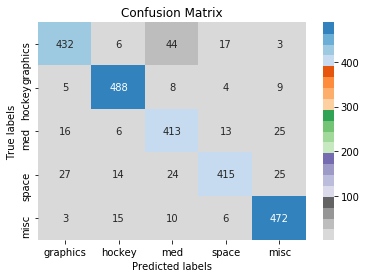

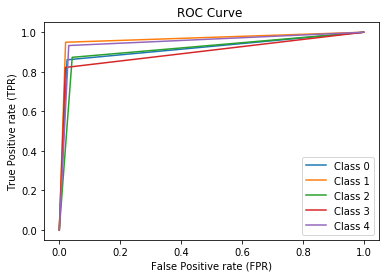

-----------------
k-value: 3
Accuracy Score: 0.8952


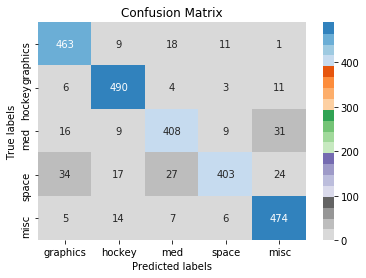

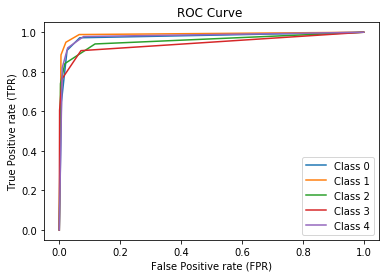

-----------------
k-value: 5
Accuracy Score: 0.89


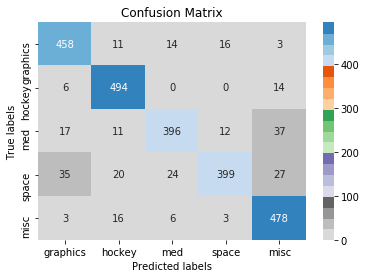

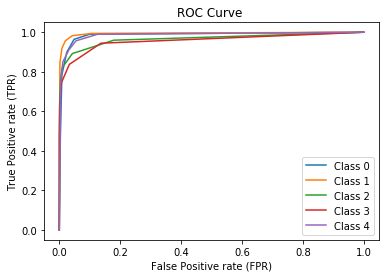

In [20]:
test_size=0.5
X_train_50_50, X_test_50_50, y_train_50_50, y_test_50_50  = splitData(X_class, y_class,test_size)

X_train_50_50_vec, X_test_50_50_vec = get_split_vectors(X_train_50_50, X_test_50_50, tf_idf_w2v_dictionary)

labels=[0,1,2,3,4]
k_values=[1,3,5]
print()

for k in k_values:
    print('-----------------\nk-value:',k)
    y_pred, softmax=knn_predict(X_train_50_50_vec, X_test_50_50_vec, y_train_50_50, labels,k)

    metrics(y_pred,y_test_50_50,softmax)

In [23]:
softmax.shape

(5, 2500)

In [32]:
# from sklearn.naive_bayes import GaussianNB,MultinomialNB

# clf = GaussianNB()
# clf.fit(X_train_50_50_vec, y_train_50_50)
# nb_pred=clf.predict(X_test_50_50_vec)
# sft=clf.predict_proba(X_test_50_50_vec)
# metrics(nb_pred,y_test_50_50,sft)

## 80:20 Split

4000 1000 4000 1000

-----------------
k-value: 1
Accuracy Score: 0.917


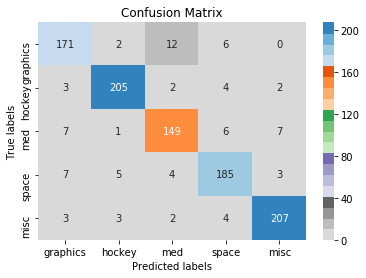

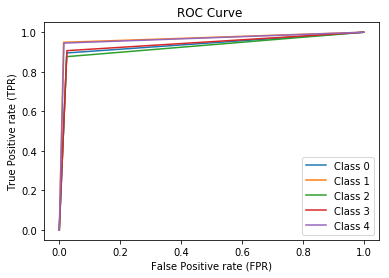

-----------------
k-value: 3
Accuracy Score: 0.91


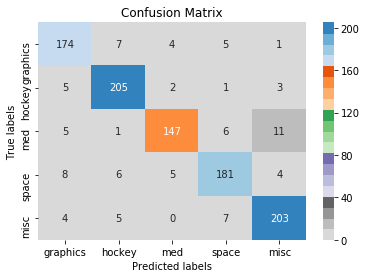

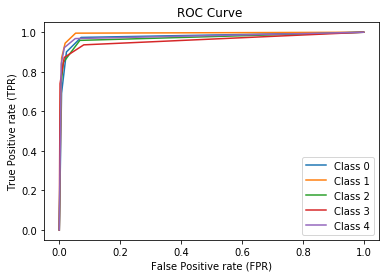

-----------------
k-value: 5
Accuracy Score: 0.911


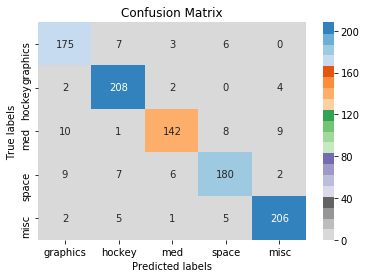

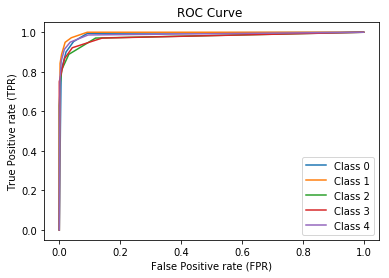

In [17]:
test_size=0.2
X_train_80_20, X_test_80_20, y_train_80_20, y_test_80_20  = splitData(X_class, y_class,test_size)

X_train_80_20_vec, X_test_80_20_vec = get_split_vectors(X_train_80_20, X_test_80_20, tf_idf_w2v_dictionary)

labels=[0,1,2,3,4]
k_values=[1,3,5]
print()
for k in k_values:
    print('-----------------\nk-value:',k)
    y_pred, softmax=knn_predict(X_train_80_20_vec, X_test_80_20_vec, y_train_80_20, labels,k)

    metrics(y_pred,y_test_80_20,softmax)

## 90:10 Split

4500 500 4500 500

-----------------
k-value: 1
Accuracy Score: 0.916


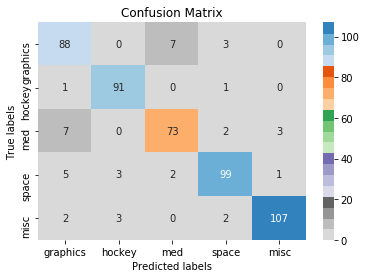

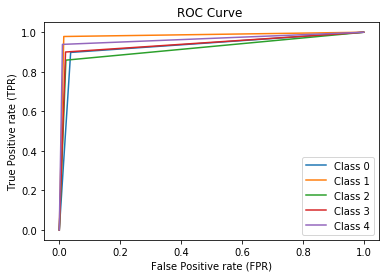

-----------------
k-value: 3
Accuracy Score: 0.914


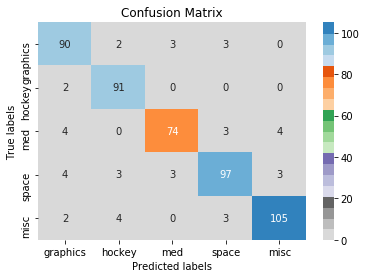

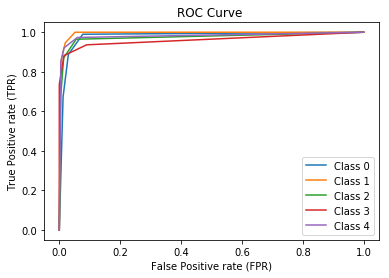

-----------------
k-value: 5
Accuracy Score: 0.924


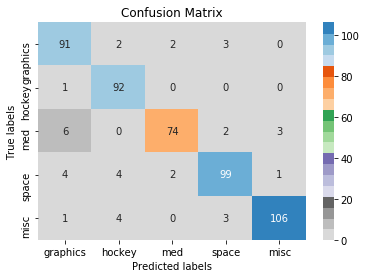

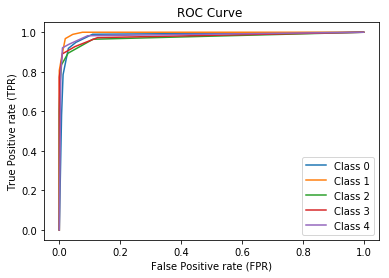

In [18]:
test_size=0.1
X_train_90_10, X_test_90_10, y_train_90_10, y_test_90_10  = splitData(X_class, y_class,test_size)

X_train_90_10_vec, X_test_90_10_vec = get_split_vectors(X_train_90_10, X_test_90_10, tf_idf_w2v_dictionary)

labels=[0,1,2,3,4]
k_values=[1,3,5]
print()
for k in k_values:
    print('-----------------\nk-value:',k)
    y_pred, softmax=knn_predict(X_train_90_10_vec, X_test_90_10_vec, y_train_90_10, labels,k)

    metrics(y_pred,y_test_90_10,softmax)